# <Spaceship Titinic 생존자 예측>
문제 유형: 이진 분류 (Binary Classification)

타깃 변수: Transported (True / False)

평가지표: Accuracy

목표 정확도: 80.5% 이상

## 1. 데이터 불러오기 및 구조 확인

In [2]:
!pip install missingno             # missingno 사용을 위해서는 설치 필요

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import warnings
warnings.filterwarnings(action='ignore') 

from pathlib import Path                   # os.보다 pathlib.Path가 더 권장되는 현대식 방법이라고 해서 사용함

BASE_PATH = Path.cwd()
DATA_PATH = BASE_PATH / "data"                         # Path로 데이터파일 경로 지정

df_train = pd.read_csv(DATA_PATH / "train.csv")
df_test = pd.read_csv(DATA_PATH / "test.csv")
submission = pd.read_csv(DATA_PATH / "sample_submission.csv")

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [16]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [17]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [19]:
print(df_train.shape)  #(891, 12)
print(df_test.shape)  #(418, 11)

submission.head()

(8693, 14)
(4277, 13)


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


- 목표는 Transported 칼럼의 True/False 여부를 예측하는 것!

In [21]:
df_train.isnull().sum()            # train data의 결측치 확인

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [22]:
df_test.isnull().sum()  # test data의 결측치 확인

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

<Axes: ylabel='count'>

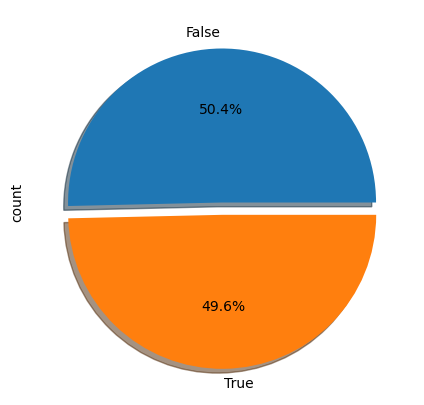

In [30]:
df_train["Transported"].value_counts()        # 차원 이동한 승객의 비율 그래프

plt.figure(figsize=(8, 5))
labels = ['False', 'True']
df_train['Transported'].value_counts().plot.pie(explode=[0, 0.08], 
                                          shadow=True,
                                          autopct='%1.1f%%',
                                          labels=labels)

- 대략 서로 절반 정도로 비슷한 비율

## 2. EDA

### 범주형 변수 HomePlanet/ CryoSleep/ Destination/ VIP 와 Transported 비교

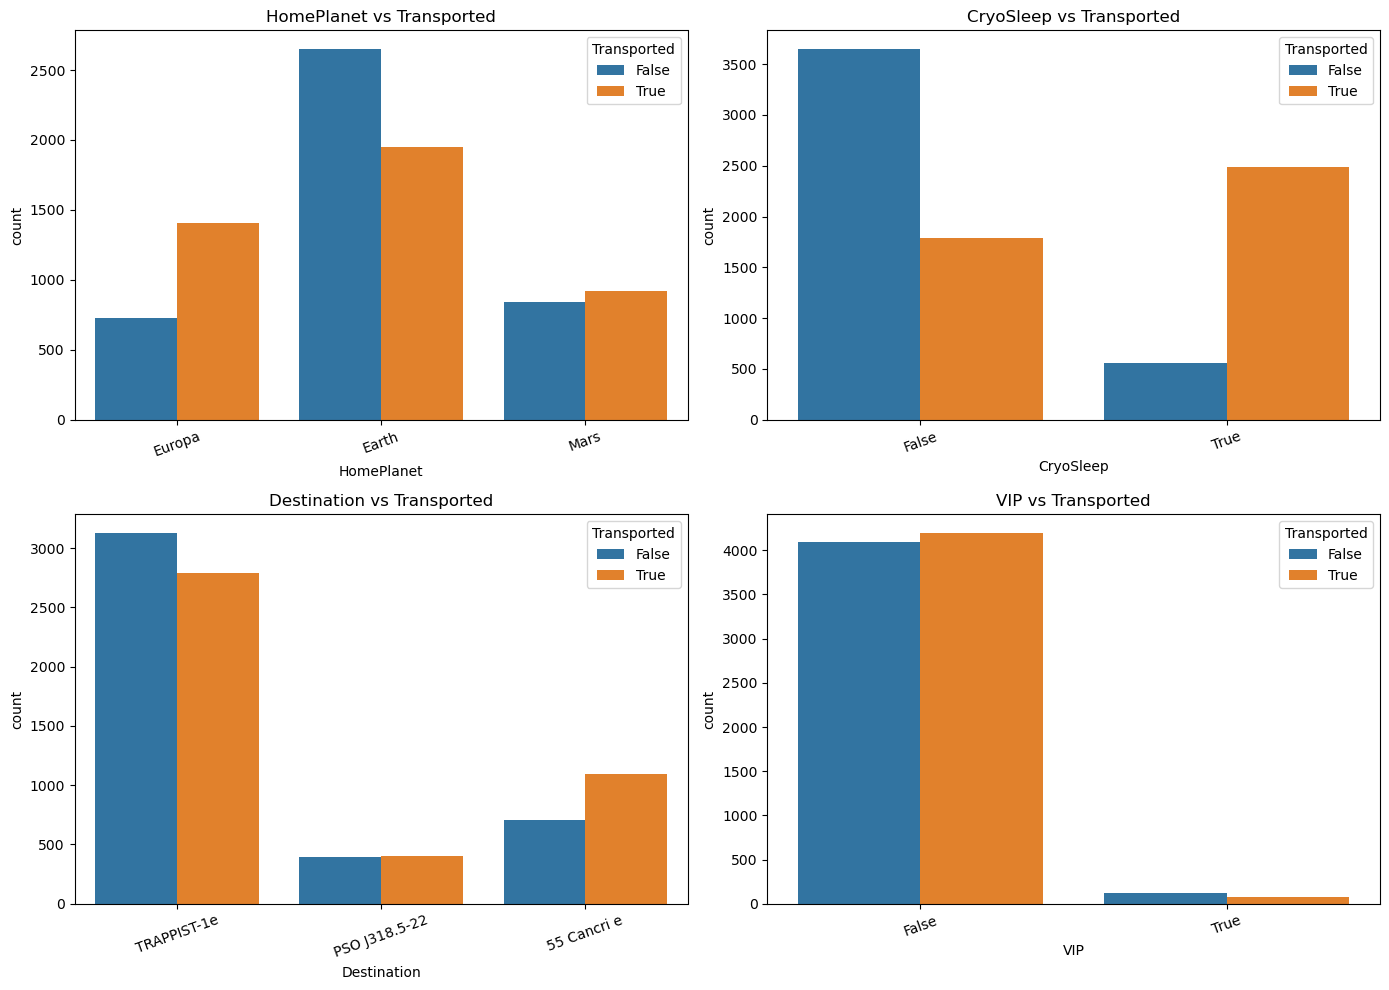

In [37]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

cat_cols = ["HomePlanet", "CryoSleep", "Destination", "VIP"]

for ax, col in zip(axes.flatten(), cat_cols):
    sns.countplot(
        data=df_train,
        x=col,
        hue="Transported",
        ax=ax
    )
    ax.set_title(f"{col} vs Transported")
    ax.tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

- 각 범주형 변수 그래프를 살펴보면 CryoSleep의 경우, True일 경우 True인 경향이, False면 False일 경향이 높음 -> 가장 유의미한 범주형 변수이며 반대로 VIP는 가장 관계없는 변수일 가능성이 크다.

### Age vs Transported

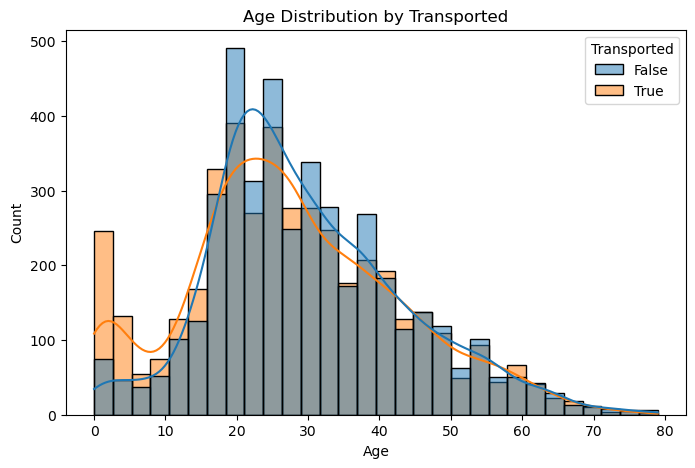

In [38]:
plt.figure(figsize=(8,5))

sns.histplot(
    data=df_train,
    x="Age",
    hue="Transported",
    bins=30,
    kde=True
)

plt.title("Age Distribution by Transported")
plt.show()

🟦 0 ~ 10세 구간

주황색(True)이 파란색(False)보다 눈에 띄게 많음 /
특히 0–5세 구간에서 True 비율 높음

- 어린 승객일수록 Transported될 확률이 상대적으로 높다.

🟦 10 ~ 20세 구간

True와 False 거의 비슷 /
일부 구간에서는 True가 약간 많음
→ 약한 차이

🟦 20 ~ 30세 구간

False가 더 많음 /
가장 많은 승객이 몰려 있음
- 전체 표본이 많은 구간이지만 Transported 확률은 평균 수준

🟦 30 ~ 50세 구간

False 비율이 점점 우세 /
True 분포가 점점 감소
- 연령이 증가할수록 Transported 확률 감소 경향

🟦 60세 이상

표본 수 매우 적음 /
True 거의 없음

→ 통계적 신뢰도는 낮음

-----------------------------------------------------------------

* 나이가 어릴수록 → Transported 비율 높음

* 나이가 많아질수록 → Transported 비율 감소

하지만 강한 예측 변수라고 보기는 힘듦

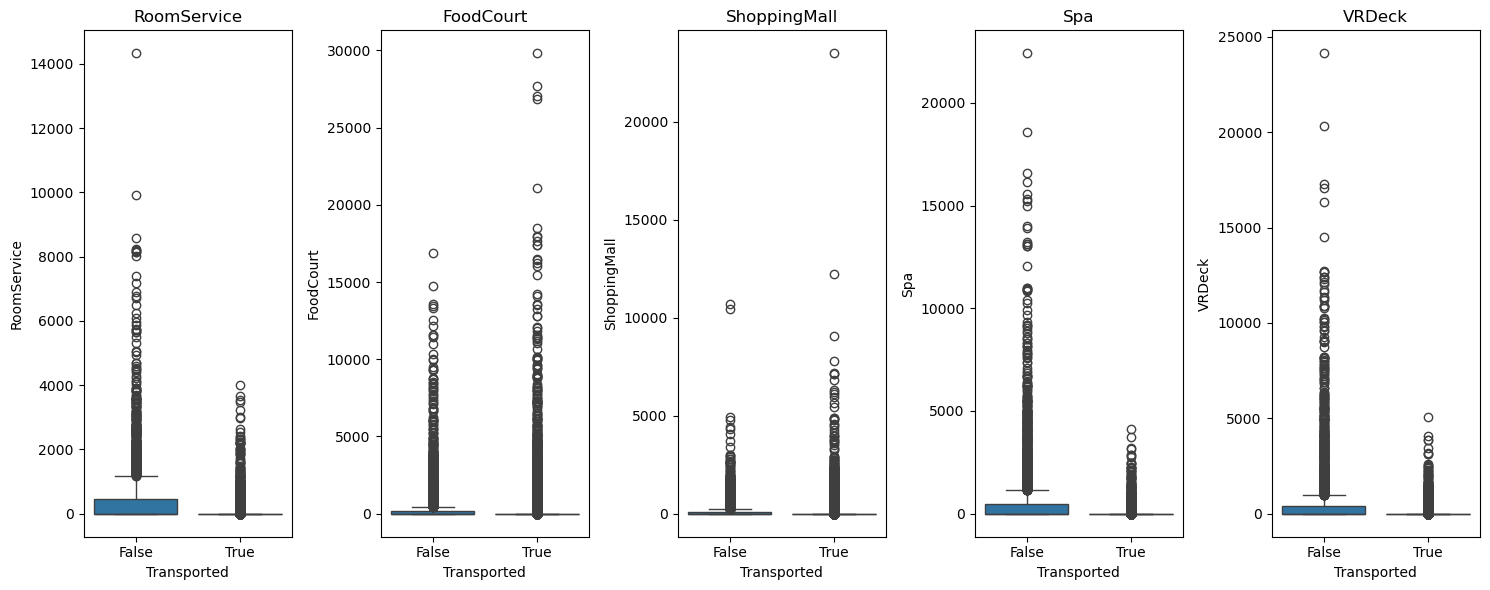

In [41]:
spend_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

plt.figure(figsize=(15,6))

for i, col in enumerate(spend_cols, 1):
    plt.subplot(1, 5, i)
    sns.boxplot(
        data=df_train,
        x="Transported",
        y=col
    )
    plt.title(col)

plt.tight_layout()
plt.show()

✅공통 패턴
* Transported = False

중앙값이 0보다 훨씬 큼

IQR(박스) 폭이 큼

고액 소비 이상치가 매우 많음


* Transported = True

중앙값이 거의 0

대부분 값이 0 근처

고액 소비자 거의 없음

-----------------------------------------

📊 변수별 해석



🧾 RoomService

False: 중앙값 존재
수천 단위 소비 다수

True: 대부분 0

👉 강한 음의 상관관계


🍔 FoodCourt

False: 최대 30,000 이상

True: 거의 소비 없음


🛍 ShoppingMall

False: 소비 폭 넓음

True: 소비 거의 없음


🧖 Spa

False: 고액 소비 다수

True: 거의 0


🎮 VRDeck

False: 높은 이상치 다수

True: 거의 소비 없음



*핵심 결론*

!! 소비 활동을 한 승객은 거의 Transported 되지 않았다 !!

## 3. 데이터 전처리

<Axes: >

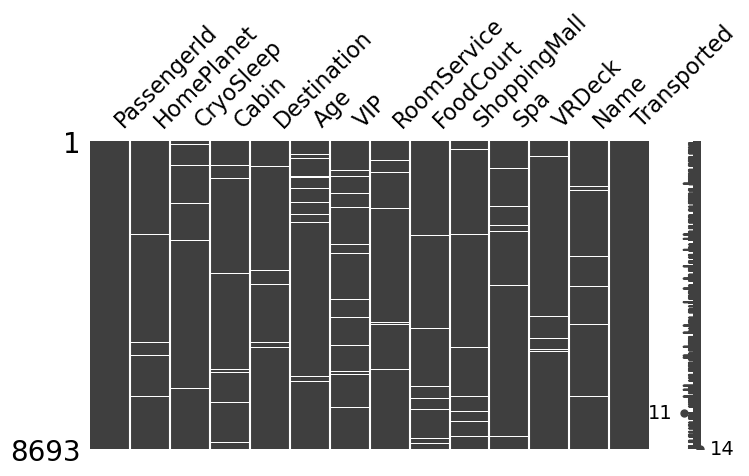

In [27]:
msno.matrix(df_train, figsize=(8, 4))  # 결측치 시각화

### * 전처리 파이프라인 * - 데이터 결합 및 분리/ 결측치 처리/ Cabin 분해/ 불필요 칼럼 제거/ 인코딩

In [43]:
from sklearn.preprocessing import LabelEncoder

# ------------------
# 0) 타깃(y) 분리
# ------------------

# - Transported는 정답(label)로, 전처리/인코딩/결측치 처리 과정에 섞이면 데이터 누수 위험
# - y로 분리하고, 입력 변수(X)에서 제거한 뒤 train/test를 합쳐 동일 전처리 수행
y = df_train["Transported"].copy()

df_train_X = df_train.drop("Transported", axis=1)

# ------------------
# 1) train+test 결합
# ------------------

# - train/test는 동일한 승객 기록 스키마를 공유하므로, 동일한 전처리를 적용해야 함
# - 컬럼 처리(결측치, 파생변수, 인코딩)를 한 번에 수행 후 다시 분리
df_all = pd.concat([df_train_X, df_test], axis=0, ignore_index=True)

# ------------------
# 2) 소비 금액(수치형) 결측치 처리 + TotalSpend 파생변수
# ------------------
spend_cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# - Transported=True 그룹에서 소비 금액의 중앙값이 0에 수렴
# - Transported=False 그룹에서 소비 금액 분포와 이상치(고액 소비)가 많이 관찰됨

# - 소비 금액 결측은 "이용 없음/청구 없음" 가능성이 높으므로 0으로 대체
# - 개별 항목을 합산한 TotalSpend는 활동성(소비 여부)의 요약 지표로 예측력 향상에 기여
df_all[spend_cols] = df_all[spend_cols].fillna(0)
df_all["TotalSpend"] = df_all[spend_cols].sum(axis=1)

# ------------------
# 3) CryoSleep 결측치 보정 (소비 금액 기반)
# ------------------

# - CryoSleep=True 일 때 Transported=True 비율이 매우 높게 나타남(강한 연관)
# - CryoSleep=True 승객은 객실에 머물며 시설 이용이 제한 → 소비 금액이 0에 가까운 경향

# - CryoSleep 결측인 경우:
#   * TotalSpend==0 이면 CryoSleep=True로 추정
#   * TotalSpend>0  이면 CryoSleep=False로 추정
# - (주의) 정답(Transported)을 사용하지 않고, 다른 입력 변수로만 결측을 보정 → 누수 아님
mask_missing_cs = df_all["CryoSleep"].isna()
df_all.loc[mask_missing_cs & (df_all["TotalSpend"] == 0), "CryoSleep"] = True
df_all.loc[mask_missing_cs & (df_all["TotalSpend"] > 0), "CryoSleep"] = False

# ------------------
# 4) Age 결측치 처리
# ------------------

# - 연령대별로 Transported 비율 차이가 일부 관찰되나 분포가 많이 겹침(보조 변수)
# - Age는 연속형이며 이상치 영향 가능

# - 중앙값(median)으로 결측치 대체 (평균보다 이상치에 덜 민감)
df_all["Age"] = df_all["Age"].fillna(df_all["Age"].median())

# ------------------
# 5) HomePlanet / Destination 결측치 처리
# ------------------

# - 범주별 Transported 비율이 완전히 동일하진 않아 보조 변수로 활용 가치 있음

# - 최빈값(mode)으로 결측치 대체 (범주형의 대표값)
df_all["HomePlanet"] = df_all["HomePlanet"].fillna(df_all["HomePlanet"].mode()[0])
df_all["Destination"] = df_all["Destination"].fillna(df_all["Destination"].mode()[0])

# ------------------
# 6) VIP 결측치 처리
# ------------------

# - VIP는 Transported와 뚜렷한 비율 차이가 크지 않음(약한 변수)
# - VIP=True 표본 자체가 적어 해석이 불안정할 수 있음

# - 결측치는 보수적으로 False로 대체 (일반 승객이 더 많다는 가정)
df_all["VIP"] = df_all["VIP"].fillna(False)

# ------------------
# 7) Cabin 분해 (Deck/Side 추출) + 불필요 컬럼 정리
# ------------------

# - Cabin은 deck/num/side 구조이며, Deck/Side는 위치 정보를 반영 → 예측에 도움 가능
# - 원본 Cabin 문자열 그대로보다 구조화된 파생 컬럼이 모델에 유리

# - Deck, Side 파생 후 원본 Cabin 제거
# - CabinNum은 수치처럼 보여도 의미가 약하고 결측/잡음이 많아 우선 제거(옵션)
df_all[["Deck", "CabinNum", "Side"]] = df_all["Cabin"].astype(str).str.split("/", expand=True)


# - Name: 개인 식별/잡음 가능성이 높아 제거 (단순 문자열은 일반화에 불리)
# - PassengerId: 식별자 성격 → 제거 (그룹 파생변수 등을 만들지 않는다면 모델에 직접 도움 적음)
# - Cabin: 분해했으므로 제거
drop_cols = ["Name", "PassengerId", "Cabin", "CabinNum"]
for c in drop_cols:
    if c in df_all.columns:
        df_all.drop(c, axis=1, inplace=True)

# ------------------
# 8) 범주형 인코딩 (Label Encoding)
# ------------------

# - HomePlanet, CryoSleep, Destination, VIP, Deck, Side 등은 범주형
# - 대부분 트리 기반 모델(RandomForest/LightGBM/XGBoost)은 정수 인코딩을 그대로 사용 가능

# - object 타입 컬럼을 LabelEncoder로 정수화
# - train+test를 합쳐서 fit하여 인코딩 매핑 불일치 방지
obj_cols = df_all.select_dtypes(include=["object"]).columns
for col in obj_cols:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col].astype(str))

# ------------------
# 9) 다시 train/test로 분리
# ------------------

# - 앞부분(len(df_train))이 훈련 데이터, 뒷부분이 테스트 데이터
X_train = df_all.iloc[:len(df_train), :].copy()
X_test = df_all.iloc[len(df_train):, :].copy()


# 모델 학습 시:
# model.fit(X_train, y)
# test_pred = model.predict(X_test)

✍️ 전처리 요약 (summarized by Chatgpt)

EDA 결과 CryoSleep과 소비 금액 변수에서 Transported와의 강한 연관성이 확인되었다.
이에 따라 소비 금액 결측치는 0으로 처리하고, 총 소비 금액(TotalSpend)을 파생변수로 생성하였다.
또한 CryoSleep 결측치는 소비 금액 정보를 활용하여 보정하였다.
위치 정보를 포함하는 Cabin 컬럼은 Deck과 Side로 분해하여 활용하였다.

## 4. 모델링

In [55]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

models = [
    RandomForestClassifier(
        n_estimators=1200,
        max_depth=14,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    ),
    RandomForestClassifier(
        n_estimators=1500,
        max_depth=18,
        min_samples_leaf=1,
        max_features="log2",
        random_state=52,
        n_jobs=-1
    ),
    RandomForestClassifier(
        n_estimators=1800,
        max_depth=20,
        min_samples_leaf=2,
        max_features=0.6,
        random_state=62,
        n_jobs=-1
    )
]

preds = []

for m in models:
    m.fit(X_train, y)
    preds.append(m.predict_proba(X_test)[:, 1])

final_pred = (np.mean(preds, axis=0) > 0.5)

submission["Transported"] = final_pred
submission.to_csv(DATA_PATH / "submission.csv", index=False)

* 목표 Kaggle score 도달 실패 -> LightGBM 으로 학습 재시도 -> RandomForest 모델 3개 앙상블 학습 시도

In [51]:
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score

# X_tr, X_val, y_tr, y_val = train_test_split(
#     X_train, y, test_size=0.2, random_state=42, stratify=y
# )

# lgbm = LGBMClassifier(
#     n_estimators=4000,
#     learning_rate=0.02,
#     num_leaves=64,
#     max_depth=-1,
#     subsample=0.9,
#     colsample_bytree=0.9,
#     min_child_samples=30,
#     reg_alpha=0.1,
#     reg_lambda=0.2,
#     random_state=42
# )

# lgbm.fit(
#     X_tr, y_tr,
#     eval_set=[(X_val, y_val)],
#     eval_metric="binary_logloss",
#     callbacks=[]  # 환경에 따라 early_stopping 콜백 추가 가능
# )

# val_pred = lgbm.predict(X_val)
# print("Validation Accuracy:", accuracy_score(y_val, val_pred))

[LightGBM] [Info] Number of positive: 3502, number of negative: 3452
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503595 -> initscore=0.014380
[LightGBM] [Info] Start training from score 0.014380
Validation Accuracy: 0.7964347326049454


### test 예측 + 제출 파일 생성

In [53]:
rf.fit(X_train, y)

test_pred = rf.predict(X_test)

submission["Transported"] = test_pred.astype(bool)
submission.to_csv("submission.csv", index=False)

## 최종 결과 : Accuracy 80.5 도달 실패

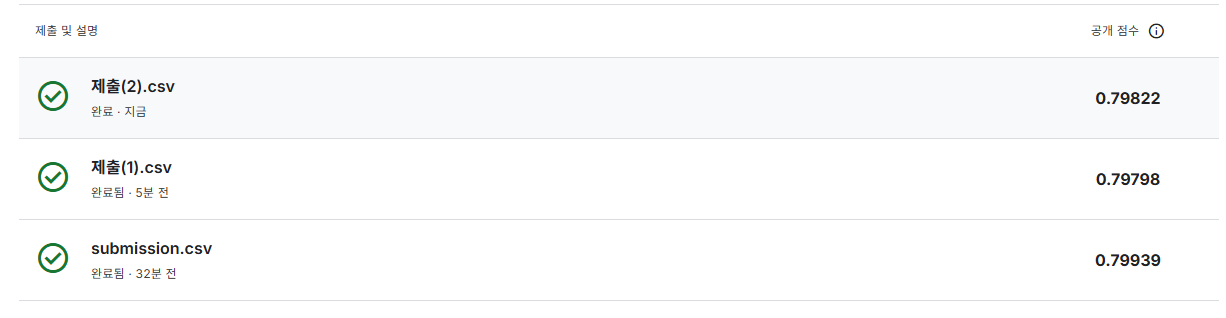

## 회고 : 처음으로 주어진 베이스라인 없이 EDA, 데이터 전처리, 모델링 까지 스스로 (여러 자료들과 GPT의 도움으로) 머신러닝 과정을 구현해보았다. 비록 목표 점수에는 도달하지는 못했지만 과정 자체가 즐겁고 학습에 도움이 되었다.